In [ ]:
!pip install discopy
!pip install pytket
!pip install pytket-qiskit

In [7]:
import numpy as np
from discopy import Ob, Ty, Box, drawing, Id, Swap, Diagram, Functor, Dim, Tensor, Cup, Cap, tensor, Word, pregroup
from discopy.quantum import qubit, H, Id, CX, QuantumGate, Ket, Bra, Measure, Discard, SWAP
# ,  circuit, sqrt, X
from pytket.extensions.qiskit import AerBackend, backends
from pytket.extensions.qiskit.backends.ibm import IBMQ
# from pytket.extensions.qiskit.backends.ibm import job_monitor
# from pytket.extensions.qiskit.backends.ibm.IBMQ.ibmq import load_account

from pytket.extensions.qiskit import AerBackend

aer = AerBackend()

# Drawing quantum circuits

A (_pure_) quantum `Circuit` is simply a recipe with qubits as ingredients and `QuantumGate` boxes as cooking steps. A quantum gate is defined by a number of qubits and a unitary matrix.

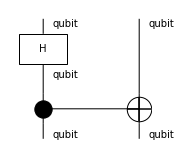

In [8]:
assert H == QuantumGate("H", 1, 1 / np.sqrt(2) * np.array([1, 1, 1, -1]), _dagger=None)

circuit = H @ Id(qubit) >> CX

circuit.draw(figsize=(2, 2), draw_type_labels=True, margins=(.1, .1))

A pure quantum circuit can be evaluated as a `Tensor` object, i.e. it is a subclass of `tensor.Diagram`.

In [9]:
assert H.eval() == H.array
assert Id(qubit).eval() == Tensor.id(Dim(2))

assert circuit.eval() == H.eval() @ Id(qubit).eval() >> CX.eval()

Pure quantum circuits are reversible. We call the reverse of a circuit its _dagger_, written with the operator `[::-1]`. 

CX >> H @ Id(1)


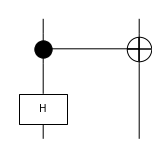

In [10]:
print(circuit[::-1])
circuit[::-1].draw(figsize=(2, 2), margins=(.1,.1))

In [11]:
assert (CX >> CX[::-1]).eval() == Id(qubit ** 2).eval()
assert np.all(np.isclose((H >> H[::-1]).eval(), Id(qubit).eval()))

Matrix multiplication is fun and all, but that's not really what quantum computers do. To simulate the quantum state that the circuit produces, we need to pre-compose it with a `Ket`, i.e. we need to initialise some qubits before we apply our circuit.
In our example `circuit`, the resulting state is the so called Bell state $\frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)$.

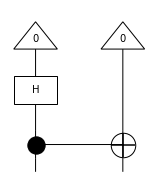

Tensor(dom=Dim(1), cod=Dim(1), array=[1.])

In [20]:
(Ket(0, 0) >> circuit).draw(figsize=(2, 2.5))
(Ket(0, 0) >> circuit).eval(backend=aer)

In [19]:
(Ket(0, 0) >> circuit).eval()

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0.70710678+0.j, 0.    +0.j, 0.    +0.j, 0.70710678+0.j])

To compute the probability of a particular measurement result, we need to post-compose our circuit with a `Bra`, the dagger of `Ket`, then apply the Born rule.

amplitude:


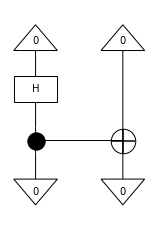

probability: 0.4999999999999999


In [ ]:
experiment = Ket(0, 0) >> circuit >> Bra(0, 0)

print("amplitude:")
experiment.draw(figsize=(2, 3))
amplitude = experiment.eval().array[0]

probability = abs(amplitude) ** 2
print("probability: {}".format(probability))

If we want to get the probability distribution over bitstrings, we need to leave the realm of purity to consider **mixed** quantum circuits with both `bit` and `qubit` ingredients.
The `Measure` box has `dom=qubit` and `cod=bit`.
Another example of a mixed box is `Discard` which computes a partial trace over a qubit.
Mixed circuits cannot be evaluated as a unitary matrix anymore.
Instead whenever the circuit is mixed, `circuit.eval()` outputs a `CQMap`: a `numpy.ndarray` with axes for the classical and quantum dimensions of the circuit.

In [ ]:
print(Discard().eval())
print(Measure().eval())

CQMap(dom=Q(Dim(2)), cod=CQ(), array=[1., 0., 0., 1.])
CQMap(dom=Q(Dim(2)), cod=C(Dim(2)), array=[1, 0, 0, 0, 0, 0, 0, 1])


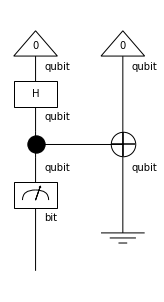

CQMap(dom=CQ(), cod=C(Dim(2)), array=[0.5+0.j, 0.5+0.j])

In [ ]:
(Ket(0, 0) >> circuit >> Measure() @ Discard()).draw(figsize=(2, 4))
(Ket(0, 0) >> circuit >> Measure() @ Discard()).eval()

Note that as for diagrams of cooking recipes, we need to introduce swaps in order to apply two-qubit gates to non-adjacent qubits. These swaps have no physical meaning, they are just an artefact of drawing circuits in 2 dimensions rather than 4. Indeed, we can forget about swaps by compiling our planar diagram into the graph-based data structure of $\mathrm{t|ket\rangle}$.

In [ ]:
circuit.to_tk()

tk.Circuit(2).H(0).CX(0, 1)

In [ ]:
(SWAP >> circuit >> SWAP).to_tk()

tk.Circuit(2).H(1).CX(1, 0)

We can execute our circuit on a $\mathrm{t|ket\rangle}$ backend (simulator or hardware) by passing it as a parameter to `eval`.

In [ ]:
aer = AerBackend()

(circuit >> Measure() @ Discard()).eval(backend=aer)

Tensor(dom=Dim(1), cod=Dim(2), array=[0.48925781, 0.51074219])

# Exercise 3.1
Run your own Bell experiment on quantum hardware! You can use IBMQ machines for free, if you're ready to wait.

In [23]:
from pytket.extensions.qiskit import AerBackend

from pytket import Circuit

c = Circuit(2,2) 
c.H(0)   
c.CX(0,1) 
c.measure_all()  


b = AerBackend()                            # connect to the backend
compiled = b.get_compiled_circuit(c)        # compile the circuit to satisfy the backend's requirements
handle = b.process_circuit(compiled, 100)   # submit the job to run the circuit 100 times
counts = b.get_result(handle).get_counts()  # retrieve and summarise the results
print(counts)

Counter({(0, 0): 55, (1, 1): 45})


In [ ]:
#TODO Fake backend

## Exercise 3.2 
Draw a circuit that evaluates to the GHZ state $\frac{1}{\sqrt{2}} (|000\rangle + |111\rangle)$.

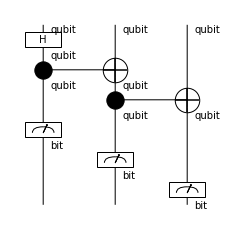

Tensor(dom=Dim(1), cod=Dim(2, 2, 2), array=[0.51660156, 0.    , 0.    , 0.    , 0.    , 0.    ,
 0.    , 0.48339844])

In [29]:
circuit = H @ Id(qubit) @ Id(qubit) >> CX @ Id(qubit) >> Id(qubit) @ CX >> Measure() @ Measure() @ Measure()
circuit.draw(figsize=(3, 3), draw_type_labels=True, margins=(.1, .1))

circuit.eval(backend=aer)

In [32]:

from pytket import Circuit

c = Circuit(3,3) 
c.H(0)   
c.CX(0,1) 
c.CX(1,2)
c.measure_all()  

b = AerBackend()                            # connect to the backend
compiled = b.get_compiled_circuit(c)        # compile the circuit to satisfy the backend's requirements
handle = b.process_circuit(compiled, 100)   # submit the job to run the circuit 100 times
counts = b.get_result(handle).get_counts()  # retrieve and summarise the results
print(counts)

Counter({(1, 1, 1): 51, (0, 0, 0): 49})


## Exercise 3.3 (harder)
Define a function that takes a number `n` and returns a circuit for the  state $\frac{1}{\sqrt{2}} (|0...0\rangle + |1...1\rangle)$.

In [ ]:
def Ket0_n(n):
    state = Ket(0)
    for i in range(1,n):
        state = state @ Ket(0)
    return(state)

def layer_i(i,n):
    if i == 0:
        layer = H
    elif i == n:
        layer = Measure()
        for k in range(1,n):
            layer = layer @ Measure()
    elif i == 1:
        layer = CX
    else:
        layer = Id(qubit)
        for k in range(1,i-1):
            layer = layer @ Id(qubit)
        layer = layer @ CX
    for k in range(i,n-1):
        layer = layer @ Id(qubit)
    return layer
    
# Ket0_n(n).draw()
# layer_i(0,3).draw()
# layer_i(1,3).draw()
# layer_i(2,3).draw()
# layer_i(3,3).draw()

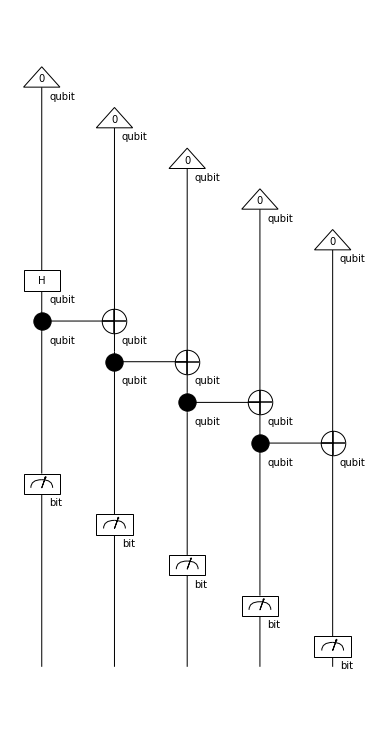

Tensor(dom=Dim(1), cod=Dim(2, 2, 2, 2, 2), array=[0.49902344, 0.    , 0.    , ..., 0.    , 0.    ,
 0.50097656])

In [ ]:
n = 5

GHZ_n = Ket0_n(n)
GHZ_n = GHZ_n >> layer_i(0,n)

for i in range(1,n):
    GHZ_n = GHZ_n >> layer_i(i,n)

GHZ_n = GHZ_n >> layer_i(n,n)    
GHZ_n.draw(figsize=(5, 10))
GHZ_n.eval(backend=aer)

## References

* Coecke, B., Sadrzadeh, M., & Clark, S. (2010) _Mathematical foundations for a compositional distributional model of meaning._ [arXiv:1003.4394](https://arxiv.org/abs/1003.4394)
* Zeng, W., & Coecke, B.  (2016) _Quantum algorithms for compositional natural language processing._ [arXiv:1608.01406](https://arxiv.org/abs/arXiv:1608.01406)
* de Felice, G., Toumi, A., & Coecke, B. (2020) _DisCoPy: Monoidal Categories in Python._ [arXiv:2005.02975](https://arxiv.org/abs/2005.02975)
* Meichanetzidis, K., Toumi, A., de Felice, G., & Coecke, B. (2020) _Grammar-Aware Question-Answering on Quantum Computers._ [arXiv:2012.03756](https://arxiv.org/abs/arXiv:2012.03756)
* Meichanetzidis, K., Gogioso, S., De Felice, G., Chiappori, N., Toumi, A., & Coecke, B. (2020) _Quantum natural language processing on near-term quantum computers._ [arXiv:2005.04147](https://arxiv.org/abs/arXiv:2005.04147)